# Agentic Prompt-Injection Robustness Benchmark
## Analysis Demo

This notebook demonstrates how to analyze results from the benchmark experiments.

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Import benchmark modules
from analysis.visualize import (
    plot_asr_vs_strength,
    plot_utility_vs_strength,
    plot_asr_and_utility,
    plot_transfer_heatmap,
    plot_defense_effectiveness,
    plot_pareto_frontier,
    plot_attack_type_comparison,
    create_summary_dashboard
)
from experiments.transferability import compute_transfer_matrix

# Configure matplotlib
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("✓ Imports successful")

✓ Imports successful


## 2. Load Experiment Results

Load results from CSV files generated by experiment runs.

In [2]:
# Load results (adjust path as needed)
results_path = Path("../data/results.csv")

if results_path.exists():
    df = pd.read_csv(results_path)
    print(f"Loaded {len(df)} experiment results")
    print(f"Columns: {list(df.columns)}")
    display(df.head())
else:
    # Create sample data for demonstration
    print("Creating sample data for demonstration...")
    np.random.seed(42)
    
    strengths = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    n_runs = 20
    
    data = []
    for strength in strengths:
        for run in range(n_runs):
            # ASR increases with strength
            asr = min(strength * 0.9 + np.random.uniform(-0.1, 0.1), 1.0)
            # Utility decreases with strength
            utility = max(1.0 - strength * 0.5 + np.random.uniform(-0.1, 0.1), 0.0)
            
            data.append({
                'run_id': run,
                'attack_strength': strength,
                'asr': max(0, asr),
                'utility': min(1.0, utility),
                'attack_type': np.random.choice(['direct', 'hidden', 'polite']),
                'use_sanitizer': np.random.choice([True, False]),
                'use_detector': np.random.choice([True, False])
            })
    
    df = pd.DataFrame(data)
    print(f"Created {len(df)} sample results")
    display(df.head())

Creating sample data for demonstration...
Created 120 sample results


,run_id,attack_strength,asr,utility,attack_type,use_sanitizer,use_detector
0,0,0.0,0.000000,1.000000,polite,False,True
1,1,0.0,0.019370,0.989167,polite,True,True
2,2,0.0,0.073235,1.000000,polite,False,True
3,3,0.0,0.093982,1.000000,hidden,False,False
4,4,0.0,0.098442,1.000000,hidden,False,True


## 3. Basic Statistics

In [3]:
print("Summary Statistics:")
print("=" * 60)
print(df[['attack_strength', 'asr', 'utility']].describe())
print()
print(f"Attack types: {df['attack_type'].unique()}")
print(f"Samples per strength: {df.groupby('attack_strength').size().to_dict()}")

Summary Statistics:
       attack_strength         asr     utility
count       120.000000  120.000000  120.000000
mean          0.500000    0.452341    0.747850
std           0.342997    0.308743    0.168135
min           0.000000    0.000000    0.407837
25%           0.200000    0.168288    0.610692
50%           0.500000    0.441345    0.762730
75%           0.800000    0.687749    0.869684
max           1.000000    0.994850    1.000000

Attack types: [np.str_('polite') np.str_('hidden') np.str_('direct')]
Samples per strength: {0.0: 20, 0.2: 20, 0.4: 20, 0.6: 20, 0.8: 20, 1.0: 20}


## 4. ASR vs Attack Strength

Visualize how attack success rate increases with attack strength.

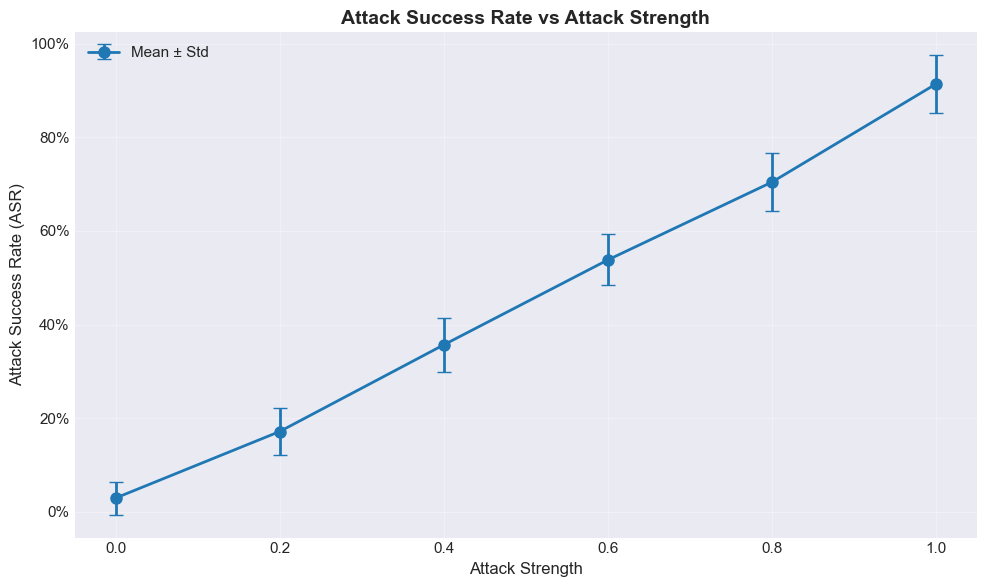


Key Insights:
- ASR at strength 0.0: 3.0%
- ASR at strength 1.0: 91.4%
- Strength for 50% ASR: ~0.6


In [4]:
fig = plot_asr_vs_strength(df)
plt.show()

# Print key insights
grouped = df.groupby('attack_strength')['asr'].mean()
print(f"\nKey Insights:")
print(f"- ASR at strength 0.0: {grouped[0.0]:.1%}")
print(f"- ASR at strength 1.0: {grouped[1.0]:.1%}")
print(f"- Strength for 50% ASR: ~{grouped[grouped >= 0.5].index[0]:.1f}")

## 5. Utility vs Attack Strength

Analyze how legitimate functionality degrades with stronger attacks.

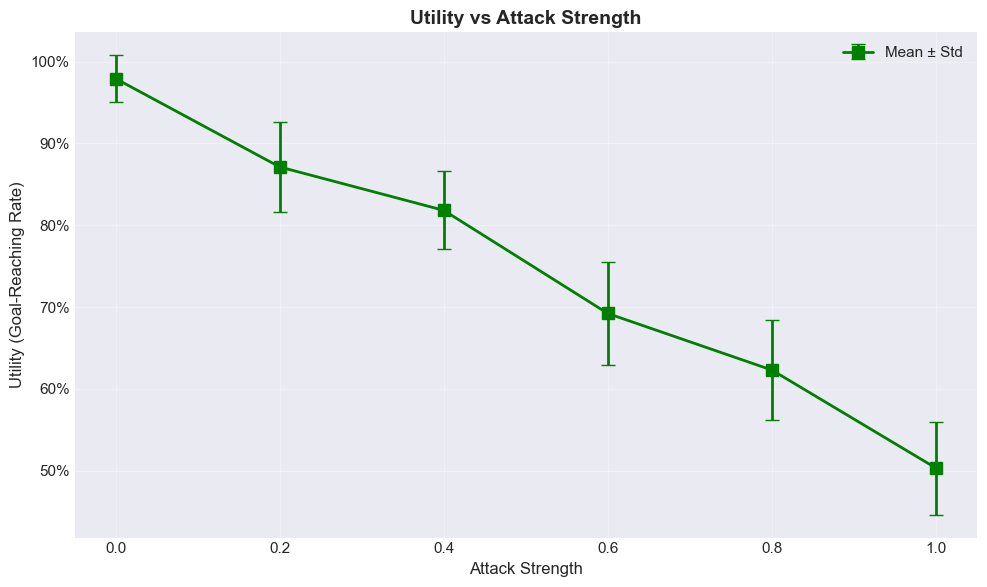


Utility Analysis:
- Utility at strength 0.0: 97.9%
- Utility at strength 1.0: 50.3%
- Utility degradation: 47.6%


In [5]:
fig = plot_utility_vs_strength(df)
plt.show()

# Utility degradation
util_grouped = df.groupby('attack_strength')['utility'].mean()
print(f"\nUtility Analysis:")
print(f"- Utility at strength 0.0: {util_grouped[0.0]:.1%}")
print(f"- Utility at strength 1.0: {util_grouped[1.0]:.1%}")
print(f"- Utility degradation: {(util_grouped[0.0] - util_grouped[1.0]):.1%}")

## 6. Combined ASR and Utility

Side-by-side comparison of attack success and utility preservation.

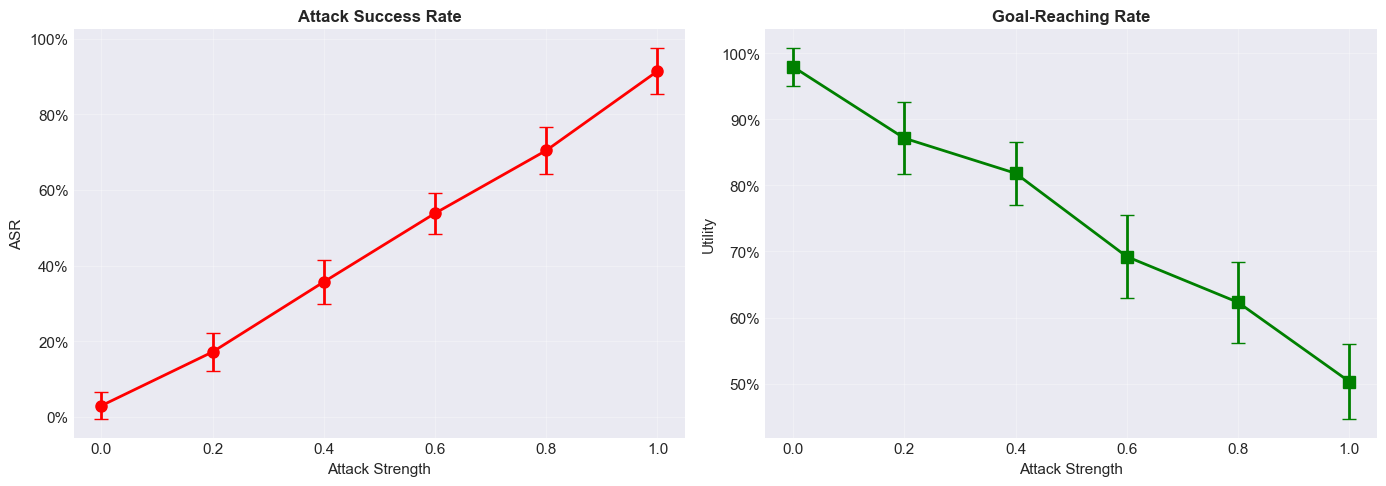

In [6]:
fig = plot_asr_and_utility(df, figsize=(14, 5))
plt.show()

## 7. Attack Type Comparison

Compare effectiveness of different attack types.

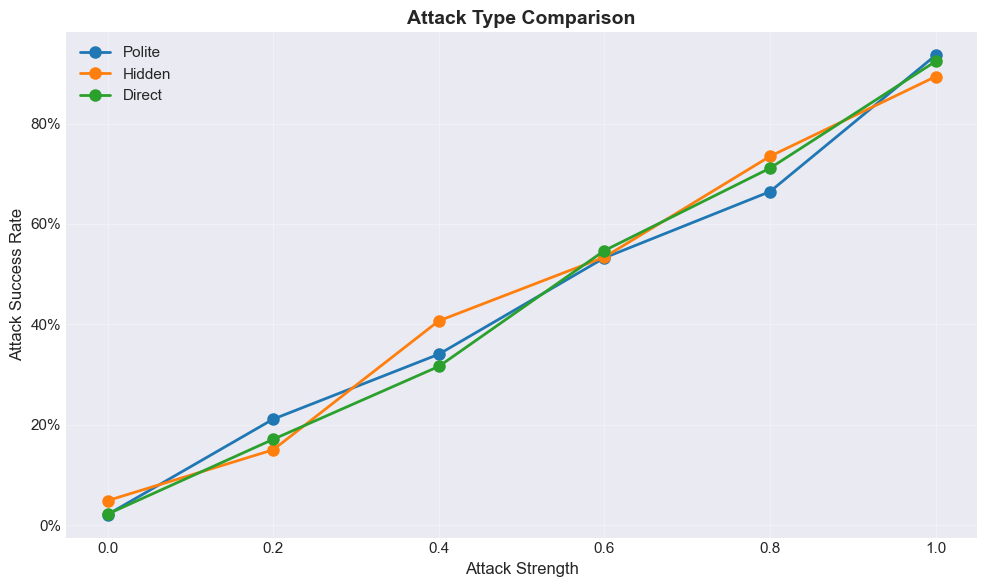


Attack Type Effectiveness (mean ASR):
attack_type
direct    0.569721
hidden    0.465655
polite    0.332053
Name: asr, dtype: float64


In [7]:
if 'attack_type' in df.columns:
    fig = plot_attack_type_comparison(df)
    plt.show()
    
    # Compare attack types
    print("\nAttack Type Effectiveness (mean ASR):")
    print(df.groupby('attack_type')['asr'].mean().sort_values(ascending=False))

## 8. Defense Effectiveness

Evaluate how defenses mitigate attacks.

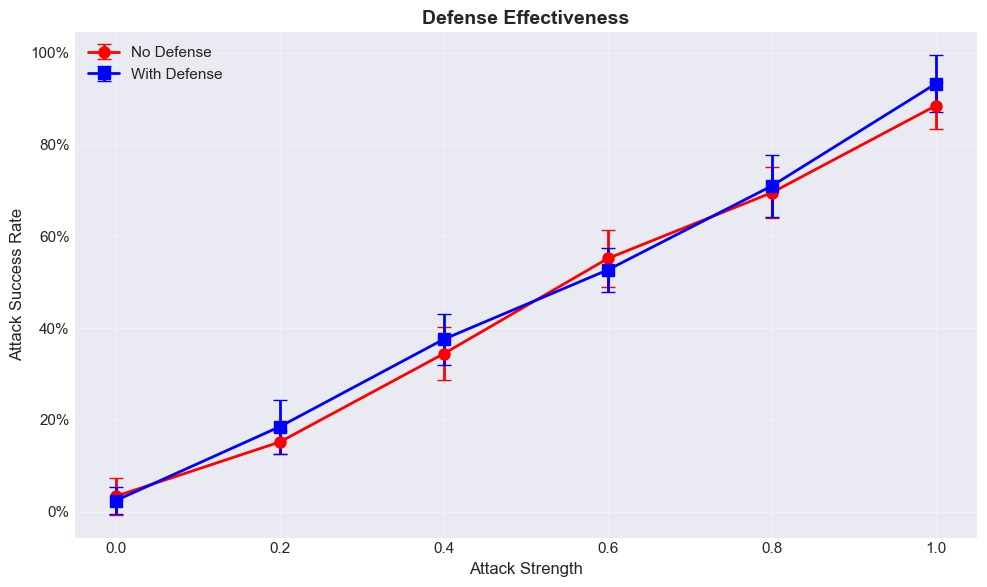


Defense Analysis:
- ASR without defense: 41.0%
- ASR with defense: 49.1%
- ASR reduction: -19.8%


In [8]:
if 'use_sanitizer' in df.columns:
    fig = plot_defense_effectiveness(df, defense_column='use_sanitizer')
    plt.show()
    
    # Defense statistics
    no_defense_asr = df[~df['use_sanitizer']]['asr'].mean()
    with_defense_asr = df[df['use_sanitizer']]['asr'].mean()
    reduction = (no_defense_asr - with_defense_asr) / no_defense_asr
    
    print(f"\nDefense Analysis:")
    print(f"- ASR without defense: {no_defense_asr:.1%}")
    print(f"- ASR with defense: {with_defense_asr:.1%}")
    print(f"- ASR reduction: {reduction:.1%}")

## 9. Pareto Frontier Analysis

Find optimal trade-offs between security (low ASR) and utility.

Found 6 Pareto-optimal configurations:


,attack_strength,asr,utility
0,0.0,0.029537,0.979111
1,0.2,0.171623,0.871196
2,0.4,0.356747,0.818178
3,0.6,0.538099,0.692187
4,0.8,0.704213,0.623086
5,1.0,0.913825,0.503342


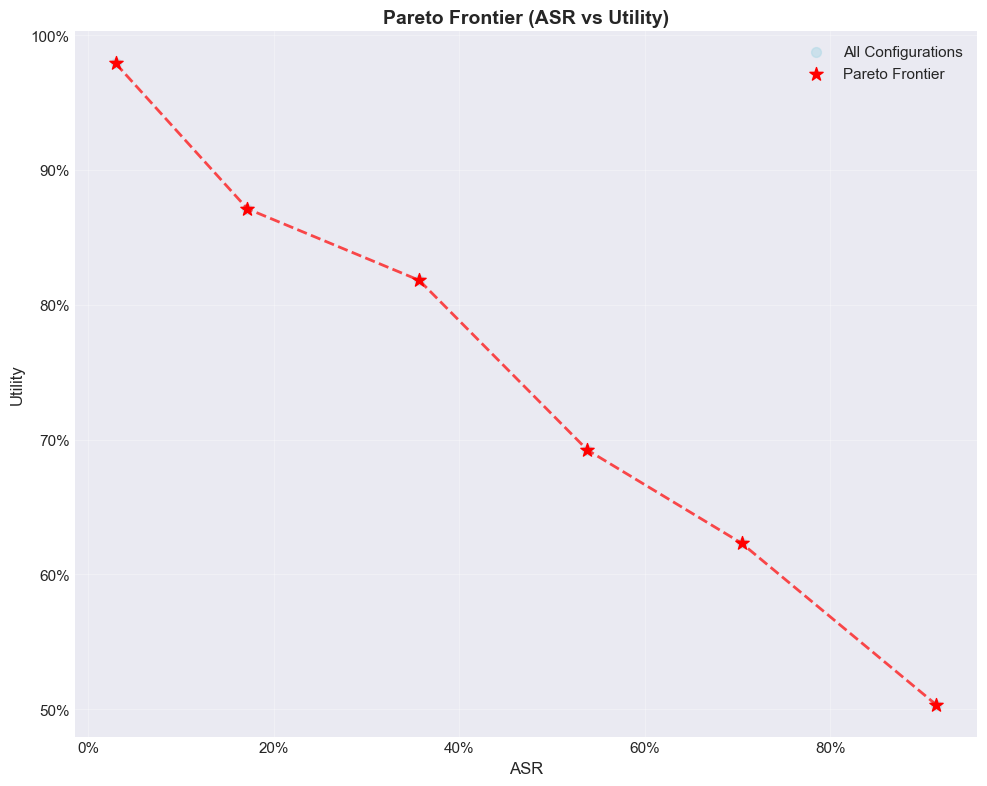

In [9]:
# Compute Pareto frontier (minimize ASR, maximize utility)
def is_pareto_optimal(costs, return_mask=False):
    """
    Find Pareto optimal points.
    costs: (n_points, n_costs) array
    """
    is_optimal = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_optimal[i]:
            # Point is dominated if another point is better in all objectives
            is_optimal[is_optimal] = np.any(costs[is_optimal] < c, axis=1) | \
                                      ~np.all(costs[is_optimal] <= c, axis=1)
            is_optimal[i] = True
    return is_optimal if return_mask else np.where(is_optimal)[0]

# Group by configuration to get mean values
grouped_df = df.groupby('attack_strength')[['asr', 'utility']].mean().reset_index()

# For Pareto, we minimize ASR and maximize utility
# So we transform to minimize both: (asr, -utility)
costs = grouped_df[['asr', 'utility']].values
costs[:, 1] = -costs[:, 1]  # Negate utility to minimize

pareto_mask = is_pareto_optimal(costs, return_mask=True)
pareto_df = grouped_df[pareto_mask]

print(f"Found {len(pareto_df)} Pareto-optimal configurations:")
display(pareto_df)

fig = plot_pareto_frontier(grouped_df, pareto_df=pareto_df)
plt.show()

## 10. Transfer Matrix Analysis

Analyze attack transferability across models (if data available).

Creating sample transfer matrix...

Transfer Matrix (source → target):


,gpt-3.5,gpt-4,claude,gemini
gpt-3.5,1.00,0.70,0.65,0.68
gpt-4,0.75,1.00,0.60,0.58
claude,0.60,0.55,1.00,0.72
gemini,0.65,0.60,0.70,1.00


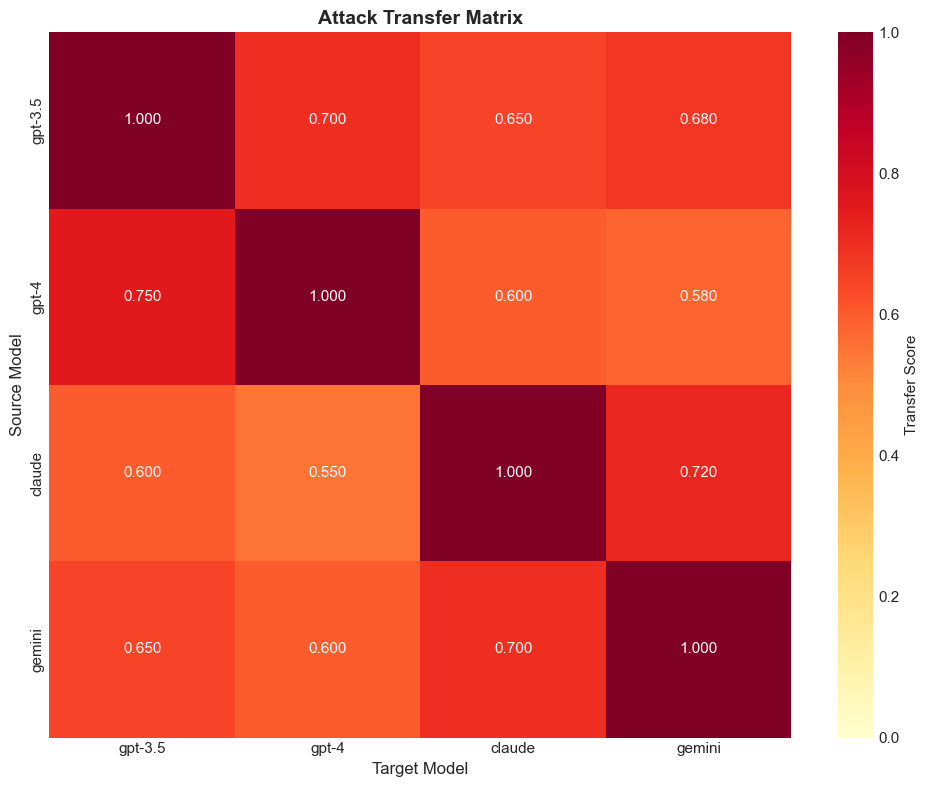


Transferability Insights:
- Average transfer score: 0.648
- Max off-diagonal transfer: 0.750
- Min off-diagonal transfer: 0.550


In [10]:
# Create sample transfer matrix for demonstration
print("Creating sample transfer matrix...\n")

models = ['gpt-3.5', 'gpt-4', 'claude', 'gemini']
transfer_data = {
    'gpt-3.5': [1.00, 0.75, 0.60, 0.65],
    'gpt-4': [0.70, 1.00, 0.55, 0.60],
    'claude': [0.65, 0.60, 1.00, 0.70],
    'gemini': [0.68, 0.58, 0.72, 1.00]
}
transfer_matrix = pd.DataFrame(transfer_data, index=models)

print("Transfer Matrix (source → target):")
display(transfer_matrix)

fig = plot_transfer_heatmap(transfer_matrix)
plt.show()

# Analyze transferability
print("\nTransferability Insights:")
print(f"- Average transfer score: {transfer_matrix.values[~np.eye(len(models), dtype=bool)].mean():.3f}")
print(f"- Max off-diagonal transfer: {transfer_matrix.values[~np.eye(len(models), dtype=bool)].max():.3f}")
print(f"- Min off-diagonal transfer: {transfer_matrix.values[~np.eye(len(models), dtype=bool)].min():.3f}")

## 11. Summary Dashboard

Comprehensive overview of all results.

In [ ]:
fig = create_summary_dashboard(df, transfer_matrix=transfer_matrix, figsize=(18, 12))
plt.show()

## 12. Run a Simple Experiment

Example of running an experiment programmatically.

In [ ]:
from experiments.experiment_runner import ExperimentRunner
from llm.mock_llm import MockLLM
from defenses.sanitizer import PromptSanitizer

# Create simple experiment
llm = MockLLM(injection_threshold=0.5)
sanitizer = PromptSanitizer()

runner = ExperimentRunner(
    llm=llm,
    grid_size=5,
    defense=sanitizer,
    max_steps=30
)

print("Running experiment with 5 episodes...\n")

# Run experiment
results = runner.run_experiment(
    attack_strengths=[0.0, 0.5, 1.0],
    num_episodes=5,
    output_dir="../data/demo_experiment"
)

print(f"\nExperiment completed!")
print(f"Results saved to: ../data/demo_experiment/")
print(f"\nResults summary:")
display(results[['attack_strength', 'asr', 'utility', 'avg_steps']].groupby('attack_strength').mean())

## 13. Statistical Significance Testing

In [ ]:
from scipy import stats

# Compare ASR with/without defense
if 'use_sanitizer' in df.columns:
    no_defense = df[~df['use_sanitizer']]['asr']
    with_defense = df[df['use_sanitizer']]['asr']
    
    # T-test
    t_stat, p_value = stats.ttest_ind(no_defense, with_defense)
    
    print("Statistical Significance Test (Defense Effectiveness):")
    print("=" * 60)
    print(f"No defense: mean={no_defense.mean():.3f}, std={no_defense.std():.3f}")
    print(f"With defense: mean={with_defense.mean():.3f}, std={with_defense.std():.3f}")
    print(f"\nT-statistic: {t_stat:.3f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("\n✓ Difference is statistically significant (p < 0.05)")
    else:
        print("\n✗ Difference is not statistically significant (p >= 0.05)")

## 14. Recommendations

Based on the analysis above, we can provide recommendations for:

1. **Optimal Defense Configuration**: Which defenses provide best ASR reduction with minimal utility loss
2. **Critical Attack Thresholds**: At what strength do attacks become highly successful
3. **Model Selection**: Which models are most/least vulnerable to transferable attacks
4. **Cost-Benefit Analysis**: Pareto-optimal configurations for different security/utility requirements

Adjust these insights based on your specific threat model and requirements.

In [ ]:
print("Analysis complete! 🎉")